In [1]:
%matplotlib inline
import pandas as pd
from datetime import datetime, date
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [60, 30]
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

In [2]:
train = pd.read_csv('train.csv', parse_dates=['pickup_datetime'])
test = pd.read_csv('test.csv', parse_dates=['pickup_datetime'])

In [3]:
print( ' train shape ',train.shape)
print( ' test shape ',test.shape)

 train shape  (1458644, 11)
 test shape  (625134, 9)


In [4]:
print([i for i in train.columns if i not in test.columns])

['dropoff_datetime', 'trip_duration']


### holiday

In [5]:
holiday = pd.read_csv('NYC_2016Holidays.csv',sep=';')
holiday.head()

,Day,Date,Holiday
0,Friday,January 01,New Years Day
1,Monday,January 18,Martin Luther King Jr. Day
2,Friday,February 12,Lincoln's Birthday
3,Monday,February 15,Presidents' Day
4,Sunday,May 08,Mother's Day


In [6]:
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holiday.head()

,Day,Date,Holiday
0,Friday,January 01 2016,New Years Day
1,Monday,January 18 2016,Martin Luther King Jr. Day
2,Friday,February 12 2016,Lincoln's Birthday
3,Monday,February 15 2016,Presidents' Day
4,Sunday,May 08 2016,Mother's Day


In [7]:
holidays = [datetime.strptime(holiday.loc[i,'Date'], '%B %d %Y').date() for i in range(len(holiday))]
holidays


[datetime.date(2016, 1, 1),
 datetime.date(2016, 1, 18),
 datetime.date(2016, 2, 12),
 datetime.date(2016, 2, 15),
 datetime.date(2016, 5, 8),
 datetime.date(2016, 5, 30),
 datetime.date(2016, 6, 19),
 datetime.date(2016, 7, 4),
 datetime.date(2016, 9, 5),
 datetime.date(2016, 10, 10),
 datetime.date(2016, 11, 11),
 datetime.date(2016, 11, 24),
 datetime.date(2016, 12, 26),
 datetime.date(2016, 7, 4),
 datetime.date(2016, 11, 8)]

### routes from open source routing machine

In [8]:
fastrout1 = pd.read_csv('fastest_routes_train_part_1.csv',
                        usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps','step_direction'])
fastrout2 = pd.read_csv('fastest_routes_train_part_2.csv',
                        usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps','step_direction'])
fastrout = pd.concat((fastrout1,fastrout2))
fastrout.head()


,id,total_distance,total_travel_time,number_of_steps,step_direction
0,id2875421,2009.1,164.9,5,left|straight|right|straight|arrive
1,id2377394,2513.2,332.0,6,none|right|left|right|left|arrive
2,id3504673,1779.4,235.8,4,left|left|right|arrive
3,id2181028,1614.9,140.1,5,right|left|right|left|arrive
4,id0801584,1393.5,189.4,5,right|right|right|left|arrive


In [9]:
right_turn = []
left_turn = []
right_turn+= list(map(lambda x:x.count('right')-x.count('slight right'),fastrout.step_direction))
left_turn += list(map(lambda x:x.count('left')-x.count('slight left'),fastrout.step_direction))

osrm_data = fastrout[['id','total_distance','total_travel_time','number_of_steps']]
osrm_data = osrm_data.assign(right_steps=right_turn)
osrm_data = osrm_data.assign(left_steps=left_turn)
osrm_data.head()

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id2875421,2009.1,164.9,5,1,1
1,id2377394,2513.2,332.0,6,2,2
2,id3504673,1779.4,235.8,4,1,2
3,id2181028,1614.9,140.1,5,2,2
4,id0801584,1393.5,189.4,5,3,1


In [10]:
osrm_test = pd.read_csv('fastest_routes_test.csv')
right_turn= list(map(lambda x:x.count('right')-x.count('slight right'),osrm_test.step_direction))
left_turn = list(map(lambda x:x.count('left')-x.count('slight left'),osrm_test.step_direction))

osrm_test = osrm_test[['id','total_distance','total_travel_time','number_of_steps']]
osrm_test = osrm_test.assign(right_steps=right_turn)
osrm_test = osrm_test.assign(left_steps=left_turn)
osrm_test.head()

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id0771704,1497.1,200.2,7,2,3
1,id3274209,1427.1,141.5,2,0,0
2,id2756455,2312.3,324.6,9,4,4
3,id3684027,931.8,84.2,4,2,1
4,id3101285,2501.7,294.7,8,3,3


### weather 

In [11]:
weather = pd.read_csv('KNYC_Metars.csv', parse_dates=['Time'])
weather.head(3)

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast


# Visualization 

In [12]:
longitude = list(train.pickup_longitude) + list(train.dropoff_longitude)
latitude = list(train.pickup_latitude) + list(train.dropoff_latitude)

print(len(train.pickup_longitude), len(train.dropoff_longitude), len(longitude) )
print(len(train.pickup_latitude), len(train.dropoff_latitude), len(latitude) )

loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude
loc_df.head()

1458644 1458644 2917288
1458644 1458644 2917288


,longitude,latitude
0,-73.982155,40.767937
1,-73.980415,40.738564
2,-73.979027,40.763939
3,-74.010040,40.719971
4,-73.973053,40.793209


In [13]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]

print(loc_df.shape)
loc_df = loc_df[(loc_df.longitude> xlim[0]) & (loc_df.longitude < xlim[1])]
loc_df = loc_df[(loc_df.longitude> xlim[0]) & (loc_df.longitude < xlim[1])]
loc_df = loc_df[(loc_df.latitude> ylim[0]) & (loc_df.latitude < ylim[1])]
loc_df = loc_df[(loc_df.latitude> ylim[0]) & (loc_df.latitude < ylim[1])]
print(loc_df.shape)

(2917288, 2)
(2895748, 2)


In [14]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_
loc_df.head()

,longitude,latitude,label
0,-73.982155,40.767937,12
1,-73.980415,40.738564,7
2,-73.979027,40.763939,12
3,-74.010040,40.719971,5
4,-73.973053,40.793209,9


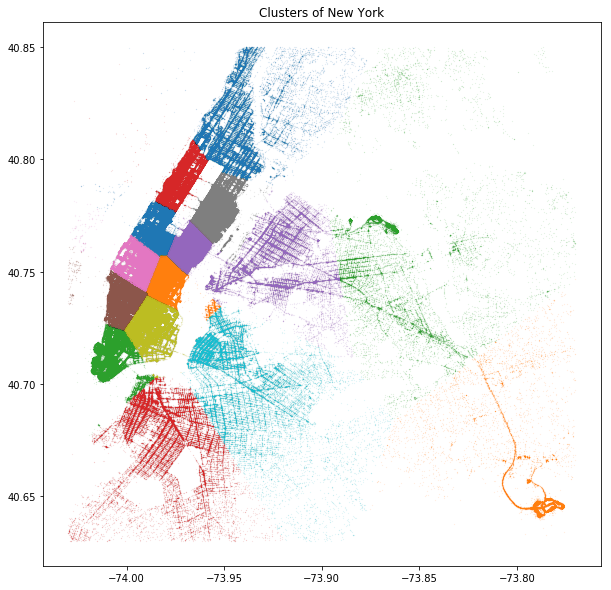

In [15]:
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

## Feature engineering

### date feature, including holidays

In [16]:
print( ' train shape ',train.shape)
print( ' test shape ',test.shape)

 train shape  (1458644, 11)
 test shape  (625134, 9)


In [17]:
for df in (train,test):
    df['year']  = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day']   = df['pickup_datetime'].dt.day
    df['hr']    = df['pickup_datetime'].dt.hour
    df['minute']= df['pickup_datetime'].dt.minute
    df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

In [18]:
train = train.assign(log_trip_duration = np.log(train.trip_duration+1))


In [19]:
time_data = pd.DataFrame(index = range(len(train)))
time_test = pd.DataFrame(index = range(len(test)))

In [20]:
def restday(yr,month,day,holidays):
    '''
    Output:
        is_rest: a list of Boolean variable indicating if the sample occurred in the rest day.
        is_weekend: a list of Boolean variable indicating if the sample occurred in the weekend.
    '''
    is_rest    = [None]*len(yr)
    is_weekend = [None]*len(yr)
    i=0
    for yy,mm,dd in zip(yr,month,day):        
        is_weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        is_rest[i]    = is_weekend[i] or date(yy,mm,dd) in holidays 
        i+=1
    return is_rest,is_weekend

In [21]:
rest_day,weekend = restday(train.year,train.month,train.day,holidays)
train['rest_day'] = rest_day
train['weekend'] = weekend

rest_day,weekend = restday(test.year,test.month,test.day,holidays)
test['rest_day'] = rest_day
test['weekend'] = weekend

train['pickup_time'] = train.hr+train.minute/60
test['pickup_time'] = test.hr+test.minute/60

In [22]:
for df in (train,test):

    df['hr_categori'] = np.nan
    df.loc[(df.rest_day == False)&(df.hr <= 9)&(df.hr >= 7), 'hr_categori'] = "rush"
    df.loc[(df.rest_day == False)&(df.hr <= 18)&(df.hr >= 16), 'hr_categori'] = "rush"
    df.loc[(df.rest_day == False)&(df.hr < 16)&(df.hr > 9), 'hr_categori'] = "day"
    df.loc[(df.rest_day == False)&(df.hr < 7)|(df.hr > 18), 'hr_categori'] = "night"
    df.loc[(df.rest_day == True)&(df.hr < 18)&(df.hr > 7), 'hr_categori'] = "day"
    df.loc[(df.rest_day == True)&(df.hr <= 7)|(df.hr >= 18), 'hr_categori'] = "night"


In [23]:
print( ' train shape ',train.shape)
print( ' test shape ',test.shape)

 train shape  (1458644, 21)
 test shape  (625134, 18)


In [24]:
print([i for i in train.columns if i not in test.columns])

['dropoff_datetime', 'trip_duration', 'log_trip_duration']


### distance feature 

In [25]:
train = train.join(osrm_data.set_index('id'), on='id')


In [26]:
test = test.join(osrm_test.set_index('id'), on='id')

In [27]:
print( ' train shape ',train.shape)
print( ' test shape ',test.shape)

 train shape  (1458644, 26)
 test shape  (625134, 23)


### weather feature

In [28]:
weather['snow']= 1*(weather.Events=='Snow') + 1*(weather.Events=='Fog\n\t,\nSnow')
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hr'] = weather['Time'].dt.hour
weather = weather[weather['year'] == 2016][['month','day','hr','Temp.','Precip','snow','Visibility']]
print(weather.shape)
weather.head()

(8739, 7)


,month,day,hr,Temp.,Precip,snow,Visibility
22,1,1,0,5.6,0.0,0,16.1
23,1,1,1,5.6,0.0,0,16.1
24,1,1,2,5.6,0.0,0,16.1
25,1,1,3,5.0,0.0,0,16.1
26,1,1,4,5.0,0.0,0,16.1


In [29]:

train = pd.merge(train, weather, on = ['month', 'day', 'hr'], how = 'left')
test = pd.merge(test, weather, on = ['month', 'day', 'hr'], how = 'left')

In [30]:
print( ' train shape ',train.shape)
print( ' test shape ',test.shape)

 train shape  (1458644, 30)
 test shape  (625134, 27)


## clustering and find speed 

In [31]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
coords

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ...,
       [ 40.74866486, -73.87660217],
       [ 40.89178848, -73.85426331],
       [ 40.76937866, -73.96932983]])

In [32]:
sample_ind = np.random.permutation(len(coords))[:1000000]
kmeans = MiniBatchKMeans(n_clusters=8, batch_size=10000).fit(coords[sample_ind])


In [33]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

train[['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude','pickup_cluster','dropoff_cluster']].head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_cluster,dropoff_cluster
0,40.767937,-73.982155,40.765602,-73.964630,5,1
1,40.738564,-73.980415,40.731152,-73.999481,5,0
2,40.763939,-73.979027,40.710087,-74.005333,5,0
3,40.719971,-74.010040,40.706718,-74.012268,0,0
4,40.793209,-73.973053,40.782520,-73.972923,1,1


In [34]:
print( ' train shape ',train.shape)
print( ' test shape ',test.shape)

 train shape  (1458644, 32)
 test shape  (625134, 29)


In [35]:
## count features
a = pd.concat([train,test]).groupby(['pickup_cluster']).size().reset_index()
b = pd.concat([train,test]).groupby([ 'dropoff_cluster']).size().reset_index()

In [36]:
a

,pickup_cluster,0
0,0,622419
1,1,447386
2,2,3
3,3,47396
4,4,62049
5,5,867622
6,6,19
7,7,36884


In [37]:
b

,dropoff_cluster,0
0,0,562177
1,1,511704
2,2,3
3,3,26725
4,4,63874
5,5,811732
6,6,25
7,7,107538


In [38]:
train = pd.merge(train, a, on = ['pickup_cluster'], how = 'left')
test = pd.merge(test, a, on = ['pickup_cluster'], how = 'left')

train = pd.merge(train, b, on = ['dropoff_cluster'], how = 'left')
test = pd.merge(test, b, on = ['dropoff_cluster'], how = 'left')

In [39]:
train['speed'] = train['total_distance'] / train['trip_duration']

In [40]:
train[['speed','total_distance','trip_duration']]

,speed,total_distance,trip_duration
0,4.415604,2009.1,455
1,3.790649,2513.2,663
2,5.207533,11060.8,2124
3,4.147786,1779.4,429
4,3.712414,1614.9,435
5,3.145598,1393.5,443
6,5.000293,1705.1,341
7,6.861380,10642.0,1551
8,5.140000,1310.7,255
9,5.540245,6786.8,1225


In [41]:
pick_up_speed = train[['speed', 'pickup_cluster']].groupby(['pickup_cluster']).mean().reset_index()
pick_up_speed = pick_up_speed.rename(columns = {'speed': 'ave_pickup_speed'})
drop_off_speed = train[['speed', 'dropoff_cluster']].groupby(['dropoff_cluster']).mean().reset_index()
drop_off_speed = drop_off_speed.rename(columns = {'speed': 'ave_dropoff_speed'})


In [42]:
print(pick_up_speed)
print(drop_off_speed)

   pickup_cluster  ave_pickup_speed
0               0          5.067469
1               1          5.494199
2               2          0.000000
3               3         11.242965
4               4          8.405111
5               5          5.047294
6               6         12.841142
7               7          6.225725
   dropoff_cluster  ave_dropoff_speed
0                0           4.986800
1                1           5.976817
2                2           0.000000
3                3          11.935437
4                4           8.552266
5                5           4.691077
6                6          35.699330
7                7           6.885238


In [43]:
train = pd.merge(train, pick_up_speed, on = ['pickup_cluster'], how = 'left')
test = pd.merge(test, pick_up_speed, on = ['pickup_cluster'], how = 'left')

train = pd.merge(train, drop_off_speed, on = ['dropoff_cluster'], how = 'left')
test = pd.merge(test, drop_off_speed, on = ['dropoff_cluster'], how = 'left')

In [44]:
train = train.drop(['speed'], axis = 1)


In [45]:
print( ' train shape ',train.shape)
print( ' test shape ',test.shape)

 train shape  (1458644, 36)
 test shape  (625134, 33)


In [46]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'year', 'month', 'day', 'hr', 'minute',
       'log_trip_duration', 'rest_day', 'weekend', 'pickup_time',
       'hr_categori', 'total_distance', 'total_travel_time', 'number_of_steps',
       'right_steps', 'left_steps', 'Temp.', 'Precip', 'snow', 'Visibility',
       'pickup_cluster', 'dropoff_cluster', '0_x', '0_y', 'ave_pickup_speed',
       'ave_dropoff_speed'],
      dtype='object')

## dummy variables

In [47]:
train[['vendor_id','store_and_fwd_flag']].head()

,vendor_id,store_and_fwd_flag
0,2,0
1,1,0
2,2,0
3,2,0
4,2,0


In [48]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek

month_train = pd.get_dummies(train['month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['day'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['day'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['hr'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['hr'], prefix='h', prefix_sep='_')
hour_cate_train = pd.get_dummies(train['hr_categori'], prefix='hc', prefix_sep='_')
hour_cate_test = pd.get_dummies(test['hr_categori'], prefix='hc', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

In [49]:
vendor_train.head()

,vi_1,vi_2
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1


In [50]:
month_train.head()

,m_1,m_2,m_3,m_4,m_5,m_6
0,0,0,1,0,0,0
1,0,0,0,0,0,1
2,1,0,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [51]:
train = train.drop(['id','vendor_id','store_and_fwd_flag','dayofweek','hr_categori','minute',
                    'month','day','hr','pickup_cluster','dropoff_cluster','dropoff_datetime', 'trip_duration'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','store_and_fwd_flag','dayofweek','hr_categori','minute',
                  'month','day','hr','pickup_cluster','dropoff_cluster'], axis = 1)


## Modeling

In [52]:
Train_Master = pd.concat([train,
                          vendor_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                         month_train,
#                          dom_train,
#                           hour_train,
                          hour_cate_train,
                          dow_train
                         ], axis=1)

In [53]:
Test_master = pd.concat([test, 
                         vendor_test,
                         store_and_fwd_flag_test,
                         cluster_pickup_test,
                         cluster_dropoff_test,
                         month_test,
#                          dom_test,
#                           hour_test,
                         hour_cate_test,
                          dow_test
                        ], axis=1)

In [54]:
Train_Master = Train_Master.drop(['pickup_datetime'],axis = 1)
Test_master = Test_master.drop(['pickup_datetime'],axis = 1)


In [55]:
Train, Test = train_test_split(Train_Master, test_size = 0.01)


In [56]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_test = Test.drop(['log_trip_duration'], axis=1)
Y_test = Test["log_trip_duration"]

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)


In [57]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [58]:
xgb_pars = {
    'objective':          'reg:linear',
    'learning_rate':      0.05,
    'max_depth':          7,
    'subsample':          0.8,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1,
    'reg_alpha':          1,
}

model = xgb.train(xgb_pars, dtrain, 500, watchlist, early_stopping_rounds=5,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:5.72047	valid-rmse:5.73117
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:5.43631	valid-rmse:5.44664
[2]	train-rmse:5.16655	valid-rmse:5.1765
[3]	train-rmse:4.91029	valid-rmse:4.91987
[4]	train-rmse:4.6669	valid-rmse:4.67614
[5]	train-rmse:4.43578	valid-rmse:4.44463
[6]	train-rmse:4.21626	valid-rmse:4.22479
[7]	train-rmse:4.00786	valid-rmse:4.01608
[8]	train-rmse:3.80999	valid-rmse:3.81789
[9]	train-rmse:3.6222	valid-rmse:3.62972
[10]	train-rmse:3.4439	valid-rmse:3.45113
[11]	train-rmse:3.27462	valid-rmse:3.28151
[12]	train-rmse:3.11407	valid-rmse:3.12063
[13]	train-rmse:2.96161	valid-rmse:2.9678
[14]	train-rmse:2.81684	valid-rmse:2.82271
[15]	train-rmse:2.67949	valid-rmse:2.68512
[16]	train-rmse:2.54923	valid-rmse:2.55454
[17]	train-rmse:2.42567	valid-rmse:2.43074
[18]	train-rmse:2.3085	valid-rmse:2.31326
[19]	train-rmse:2.19764	valid-rmse:2.20206
[20]	train-r

[180]	train-rmse:0.397335	valid-rmse:0.389421
[181]	train-rmse:0.397263	valid-rmse:0.389382
[182]	train-rmse:0.397028	valid-rmse:0.38911
[183]	train-rmse:0.396945	valid-rmse:0.389066
[184]	train-rmse:0.396888	valid-rmse:0.389074
[185]	train-rmse:0.396802	valid-rmse:0.389077
[186]	train-rmse:0.396648	valid-rmse:0.388924
[187]	train-rmse:0.396456	valid-rmse:0.388787
[188]	train-rmse:0.396393	valid-rmse:0.388748
[189]	train-rmse:0.396361	valid-rmse:0.388754
[190]	train-rmse:0.396299	valid-rmse:0.388748
[191]	train-rmse:0.396193	valid-rmse:0.388713
[192]	train-rmse:0.396101	valid-rmse:0.388645
[193]	train-rmse:0.395984	valid-rmse:0.388592
[194]	train-rmse:0.395851	valid-rmse:0.388462
[195]	train-rmse:0.39574	valid-rmse:0.388382
[196]	train-rmse:0.39559	valid-rmse:0.388225
[197]	train-rmse:0.395531	valid-rmse:0.38821
[198]	train-rmse:0.395362	valid-rmse:0.388051
[199]	train-rmse:0.395299	valid-rmse:0.387996
[200]	train-rmse:0.395133	valid-rmse:0.387871
[201]	train-rmse:0.395073	valid-rmse:0

In [59]:
fscores = model.get_fscore()

In [60]:
#top_50_list = sorted(fscores, key=fscores.get, reverse=True)[:50]

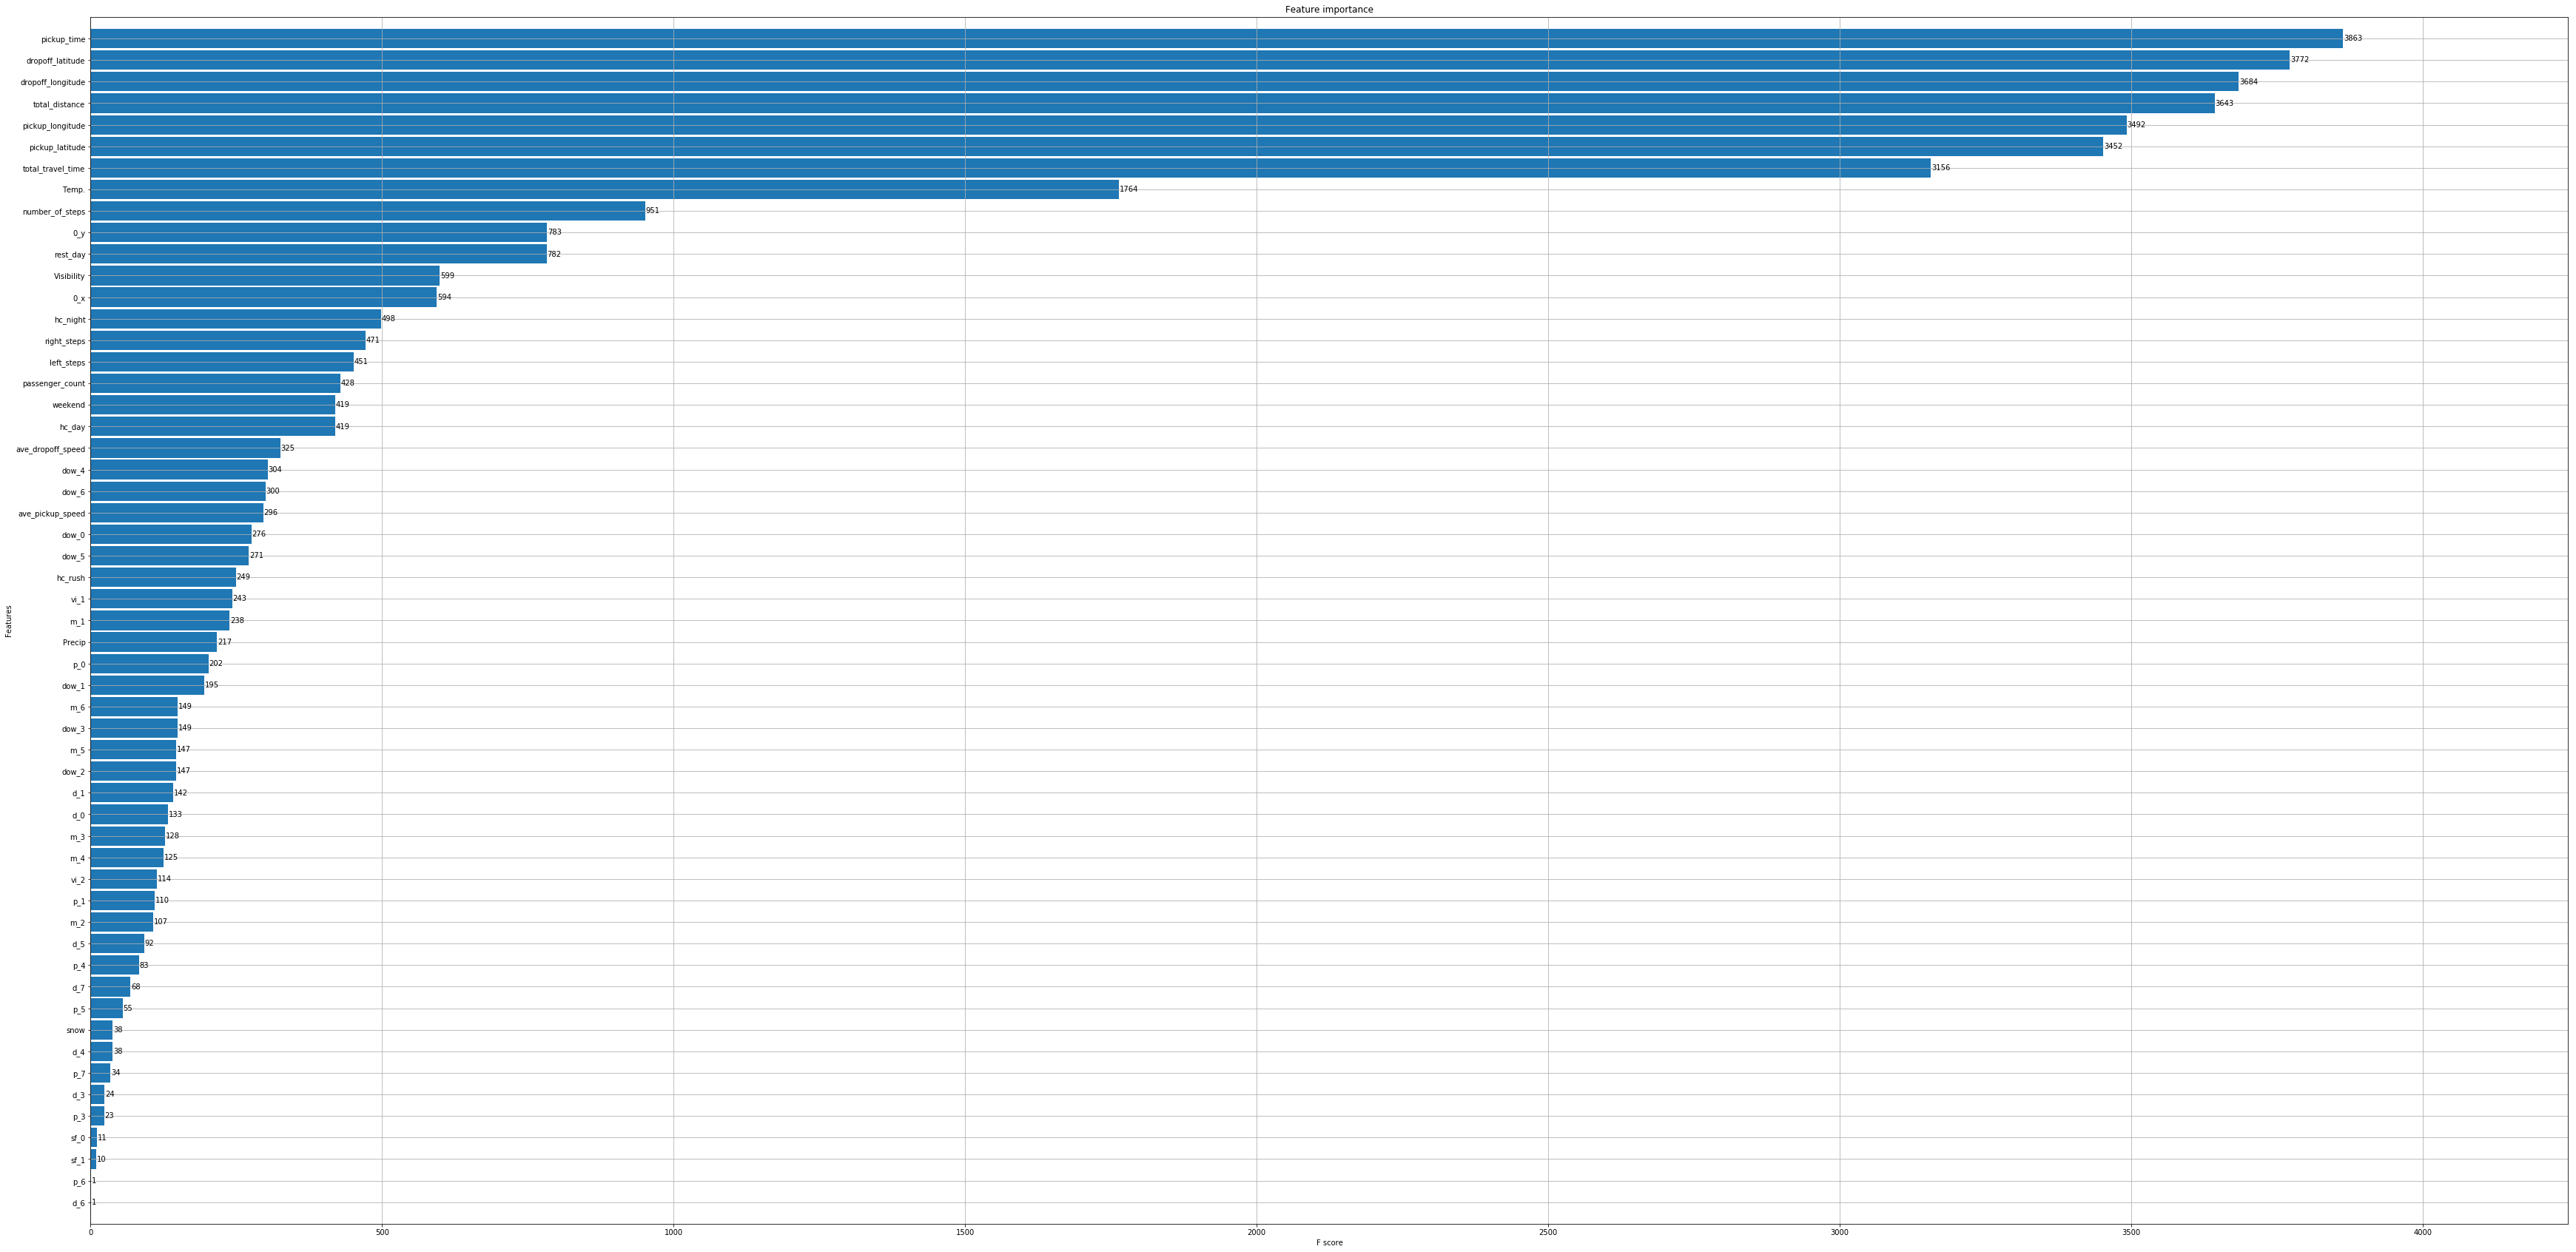

In [61]:
xgb.plot_importance(model, max_num_features=70, height=0.9)


In [62]:
pred = model.predict(dtest)
# pred = xgb_param_30.predict(dtest)
pred = np.exp(pred) - 1

In [63]:
submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission.csv", index=False)
